#  Example 1: noisy pendulum

Consider the nonlinear ODE model for the oscillations of a noisy pendulum with unit mass and length $L,$

 $$
	\frac{\mathrm{d}^{2}\theta}{\mathrm{d} t^{2}}+\frac{g}{L}\sin\theta+w(t)=0
	$$

where $\theta$ is the angular displacement of the pendulum, $g$ is the gravitational constant, $L$ is the pendulum's length, and $w(t)$ is a white noise process. This is rewritten in state space form,

 $$
	\dot{\mathbf{x}}+\mathcal{M}(\mathbf{x})+\mathbf{w}=0,
	$$

 where 

 $$
	\mathbf{x}=\left[\begin{array}{c}
		x_{1}\\
		x_{2}
	\end{array}\right]=\left[\begin{array}{c}
		\theta\\
		\dot{\theta}
	\end{array}\right],\quad
     \mathcal{M}(\mathbf{x})=\left[\begin{array}{c}
		x_{2}\\
		-\dfrac{g}{L}\sin x_{1}
	\end{array}\right],\quad
    \mathbf{w}=\left[\begin{array}{c}
		0\\
		w(t)
	\end{array}\right].
	$$

Suppose that we have discrete, noisy measurements of the horizontal component of the position, $\sin (\theta).$ Then the measurement equation is scalar,

 $$
	y_k = \sin \theta_k + v_k, 
	$$

where $v_k$ is a zero-mean Gaussian random variable with variance $R.$ The system is thus nonlinear in state and measurement and the state-space system is of the general form seen above. A simple discretization, based on Euler's method produces

$$	\begin{align*}
		\mathbf{x}_{k} & =\mathcal{M}(\mathbf{x}_{k-1})+\mathbf{w}_{k-1}\\
		  {y}_{k} & = \mathcal{H}_{k}(\mathbf{x}_{k}) + {v}_{k}, 
	\end{align*} $$

where 

$$
\mathbf{x}_{k}=\left[\begin{array}{c}
	x_{1}\\
	x_{2}
\end{array}\right]_{k}, \quad \mathcal{M}(\mathbf{x}_{k-1})=\left[\begin{array}{c}
	x_1 + \Delta t x_{2}\\
	x_2 - \Delta t  \dfrac{g}{L}\sin x_{1}
\end{array}\right]_{k-1},  \quad  \mathcal{H}(\mathbf{x}_{k}) = [\sin x_{1}]_k . 
$$

The noise terms have distributions

$$
\mathbf{w}_{k-1}\sim\mathcal{N}(\mathbf{0},Q),\quad v_{k}\sim\mathcal{N}(0,R),
$$

where the process covariance matrix is

$$
Q=\left[\begin{array}{cc}
	q_{11} & q_{12}\\
	q_{21} & q_{22}
\end{array}\right],
$$	

with components (see KF example for 2D motion tracking),

$$
q_{11}=q_{c}\frac{\Delta t^{3}}{3},\quad q_{12}=q_{21}=q_{c}\frac{\Delta t^{2}}{2},\quad q_{22}=q_{c}\Delta t,
$$

and $q_c$ is the continuous process noise spectral density.

:::{admonition} Simulations
:class: tip

In the simulations, we take: (see also Extended Kalman Filter example)

- 500 time steps with $\Delta t = 0.01.$
- Noise levels $q_c=0.01$ and $R=0.1.$
- Initial angle $x_1 = 1.8$ and initial angular velocity $x_2 = 0.$
- Initial diagonal state covariance of $0.1.$
:::


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
np.random.seed(6)

# initialize and set up all matrices
q = 0.1 #0.01     # process noise
r = 0.1 #0.02 #0.1      # measurement noise
# need to add the ensemble dimension
Ne = 10   # number of ensemble members
Nx = 2    # state dimension
Ny = 1    # observation dimension
Nt = 500  # time dimension
dt = 0.01 # time step
g  = 9.81 # gravitational acceleration

x_0 = np.array([1.5, 0.])   # Initial state

m_0 = np.array([1.6, 0.])   # Initial state estimate (slightly off)
#P_0 = np.array([[0.1, 0.], 
#                [0., 0.1]]) # Initial estimate covariance
P_0 = np.array([[r, 0.], 
                [0., r]]) # Initial estimate covariance


sig_w = q # process noise
sig_v = r # measurement noise

Q  = sig_w**2 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                          [dt ** 2 / 2, dt]])
R  = sig_v**2 * np.eye(Ny)

# Observation operator (nonlinear)
def Hx(x):
    return np.array([np.sin(x[0])]) 

# State dynamics (nonlinear)
def Ax(x, dt):
    m = np.array([x[0] + dt*x[1],
                  x[1] - g*dt* np.sin(x[0])])
    return m

## Generate noisy observations

To generate the noisy observations, we have 2 options

1. Use an accurate RK4 method.
2. Use a simpler, first-order Euler method.

Whatever the approach chosen, it must be used both for the observation generation and for the state evolution within the Kalman filter.

We will use the simpler Euler approximation. For reference, here is the RK4 method.

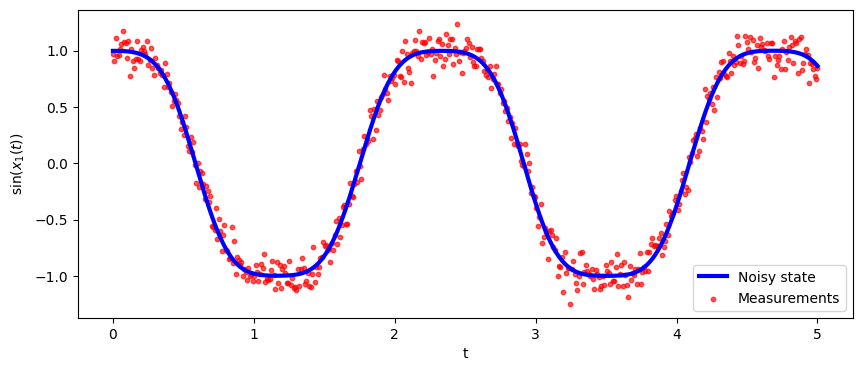

In [2]:
def Pendulum(state, *args): #nonlinear pendulum
    g = args[0]
    L = args[1]
    x1, x2 = state #Unpack the state vector
    f = np.zeros(2) #Derivatives
    f[0] = x2
    f[1] = -g/L * np.sin(x1)
    return f 

def RK4(rhs, state, dt, *args):
    
    k1 = rhs(state,         *args)
    k2 = rhs(state+k1*dt/2, *args)
    k3 = rhs(state+k2*dt/2, *args)
    k4 = rhs(state+k3*dt,   *args)

    new_state = state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    return new_state

#np.random.seed(55)
# Solve system and generate noisy observations
T = np.linspace(0, Nt, Nt)
#x0True = np.array([1.8, 0.0]) # True initial conditions
x0True = np.array([1.5, 0.0]) # True initial conditions
#time integration
chol_Q = np.linalg.cholesky(Q) # noise std dev.
sqrt_R = np.sqrt(R)
xxTrue = np.zeros([Nx, Nt])
xxTrue[:,0] = x0True
yy = np.zeros((Nt, Ny))
yy[0] = np.sin(xxTrue[0, 0]) + sig_v * np.random.randn() # must initialize correctly!
for k in range(Nt-1):
    w_k = chol_Q @ np.random.randn(2)
    xxTrue[:,k+1] = RK4(Pendulum, xxTrue[:,k], dt, g, 1.0) + w_k
    yy[k+1,0] = np.sin(xxTrue[0, k+1]) + sig_v * np.random.randn()

# plot results
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,4))
ax.plot(T*dt, np.sin(xxTrue[0, :]), color='b', linewidth = 3, label="Noisy state")
ax.scatter(T*dt, yy[:,0], marker="o", label="Measurements", color="red", alpha=0.66, s=10)
ax.set_xlabel('t')
ax.set_ylabel("$\sin(x_1(t))$", labelpad=5)
ax.legend()
plt.show()

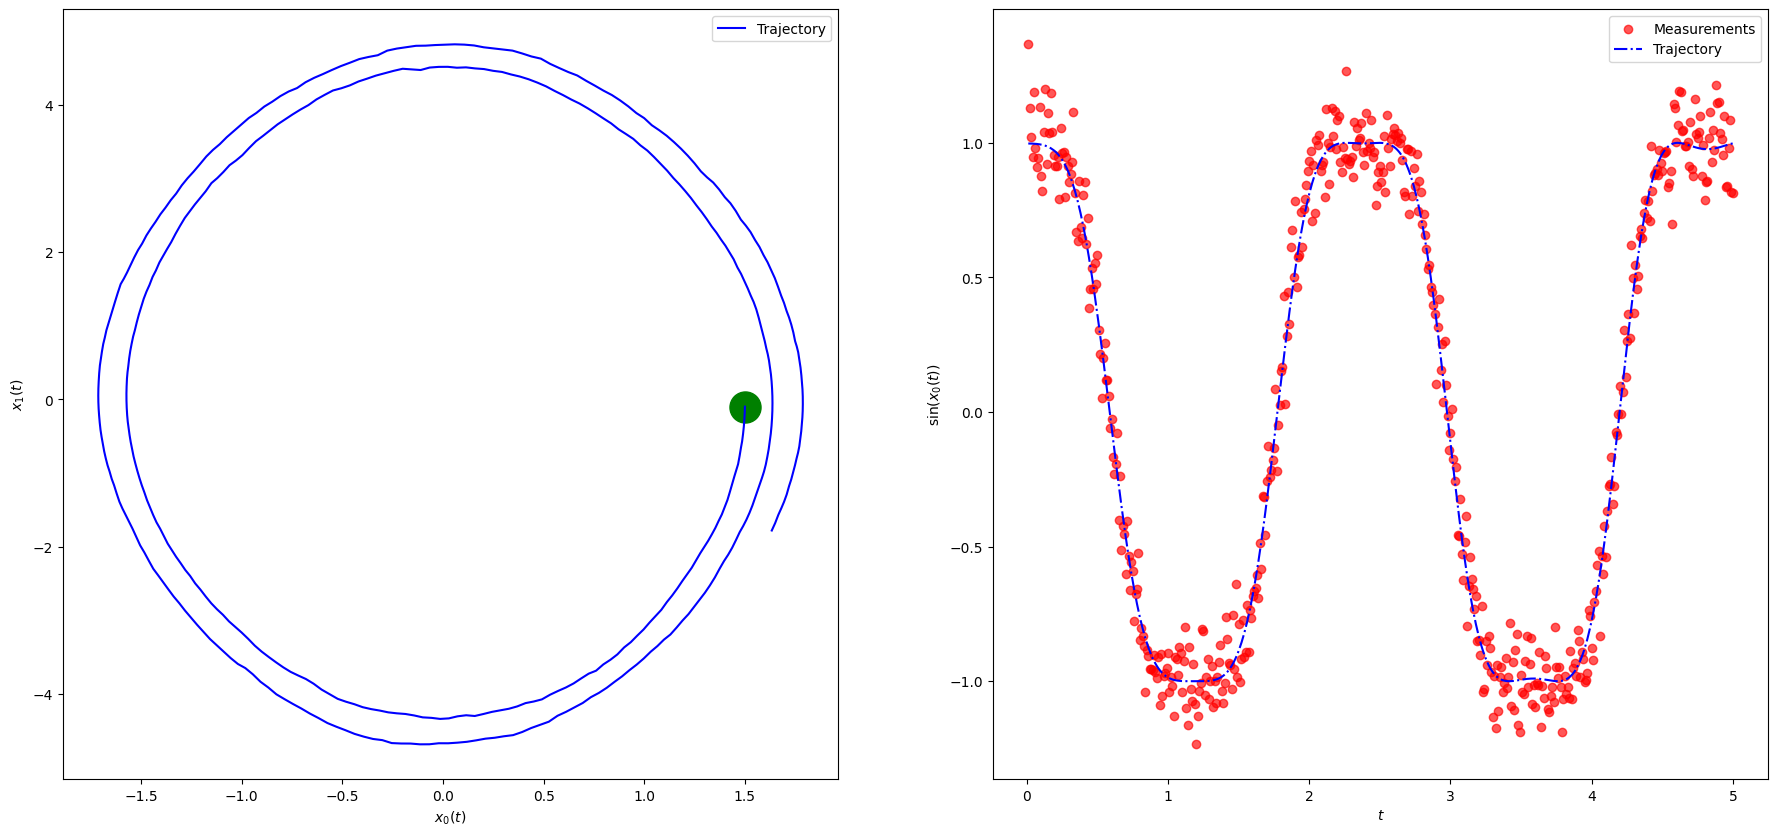

In [3]:
# Use Euler method
from common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum
random_state = RandomState(1)
steps = Nt
x_0 = x0True
#timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)
#plot_pendulum(timeline, observations, states, "Trajectory")
y = np.zeros((Nt, Ny))
timeline, xTrue, y[:, 0] = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)
plot_pendulum(timeline, y, xTrue, "Trajectory")

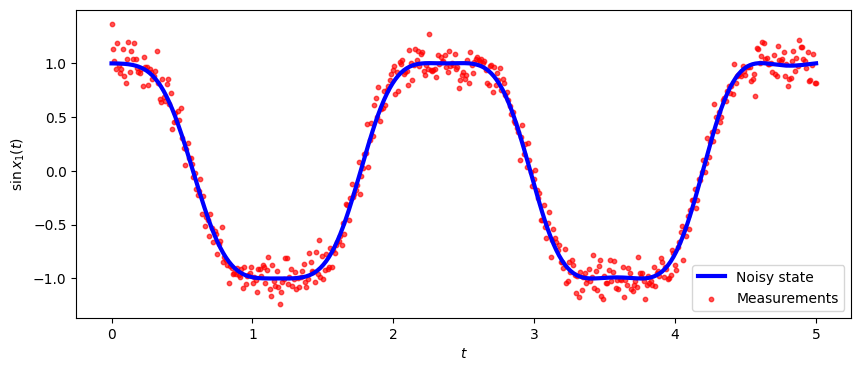

In [4]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,4))
ax.plot(T*dt, np.sin(xTrue[:, 0]), color='b', linewidth = 3, label="Noisy state")
ax.scatter(T*dt, y[:,0], marker="o", label="Measurements", color="red", alpha=0.66, s=10)
ax.legend()
plt.ylabel('$\sin x_1(t)$')
plt.xlabel('$t$')
plt.show()

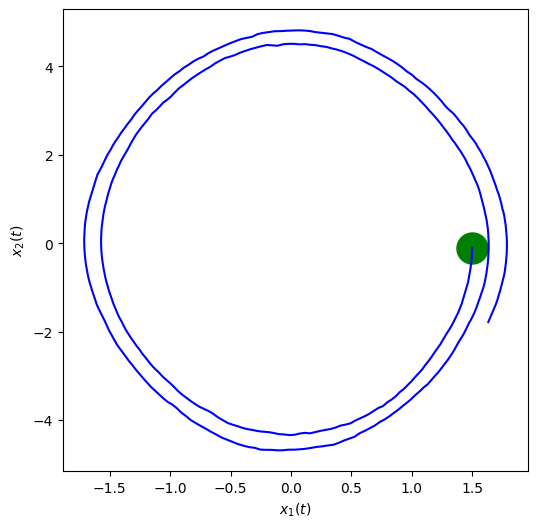

In [5]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6))
#plt.plot(xTrue[0, :], xTrue[1, :], 'b')
plt.plot(xTrue[:, 0], xTrue[:, 1], 'b')
plt.scatter(xTrue[0, 0], xTrue[0, 1], marker="o", color="green", s=500)
plt.xlabel('$x_1(t)$')
plt.ylabel('$x_2(t)$')
plt.show()

## Ensemble Kalman Filter

In [10]:
def ens_kalman_filter(m_0, P_0, Q, R, Ne, dt, Y):
    Nx = m_0.shape[-1]
    Nt, Ny = Y.shape
    
    enkf_m = np.empty((Nt, Nx))
    enkf_P = np.empty((Nt, Nx, Nx))
    X      = np.empty((Nx, Ne))
    HXf    = np.empty((Ny, Nx))

    X[:,:] = np.tile(m_0, (Ne,1)).T  + np.linalg.cholesky(P_0)@np.random.randn(Nx, Ne) # initial ensemble state
    P        = P_0 # initial state covariance
    enkf_m[0, :]    = m_0
    enkf_P[0, :, :] = P_0
    
    for i in range(Nt-1):
        # ==== predict/forecast ====
        Xf = Ax(X[:,:],dt) + np.linalg.cholesky(Q)@np.random.randn(Nx, Ne) # predict state ensemble
        mX = np.mean(Xf, axis=1)        # state ensemble mean
        Xfp = Xf - mX[:, None]          # state forecast anomaly
        #Phat = Xfp @ Xfp.T / (Ne - 1)  # predict covariance (not needed)
        # ==== prepare =====
        HXf = Hx(Xf)                    # nonlinear observation
        mY = np.mean(HXf, axis=1)       # observation ensemble mean
        HXp = HXf - mY[:, None]         # observation anomaly
        S = (HXp @ HXp.T)/(Ne - 1) + R  # observation covariance        
        K = linalg.solve(S, HXp @ Xfp.T, assume_a="pos").T  / (Ne - 1)  # Kalman gain
        # === perturb y and compute innovation ====
        ypert = Y[i,:] +  np.linalg.cholesky(R)@np.random.randn(Ny, Ne)
        d = ypert - HXf
        # ==== correct/analyze ====
        X[:,:] = Xf + K @ d         # update state ensemble
        mX = np.mean(X[:,:], axis=1)# state analysis ensemble mean
        Xap = X[:,:] - mX[:, None]  # state analysis anomaly
        P = Xap @ Xap.T / ( Ne - 1)     # update covariance
        # ==== save ====
        enkf_m[i+1] = mX                # save KF state estimate (mean)
        enkf_P[i+1] = P                 # save KF error estimate (covariance)
    return enkf_m, enkf_P

In [11]:
# initialize state and covariance
#m_0 = np.array([1.6, 0.])  # Slightly off
#P_0 = np.array([[0.1, 0.], 
#                [0., 0.1]])

enkf_m, enkf_P = ens_kalman_filter(m_0, P_0, Q, R, Ne, dt, y)

#rmse_ekf = rmse(ekf_m[:, :1], states[:, :1])
#print(f"EKF RMSE: {rmse_ekf}")

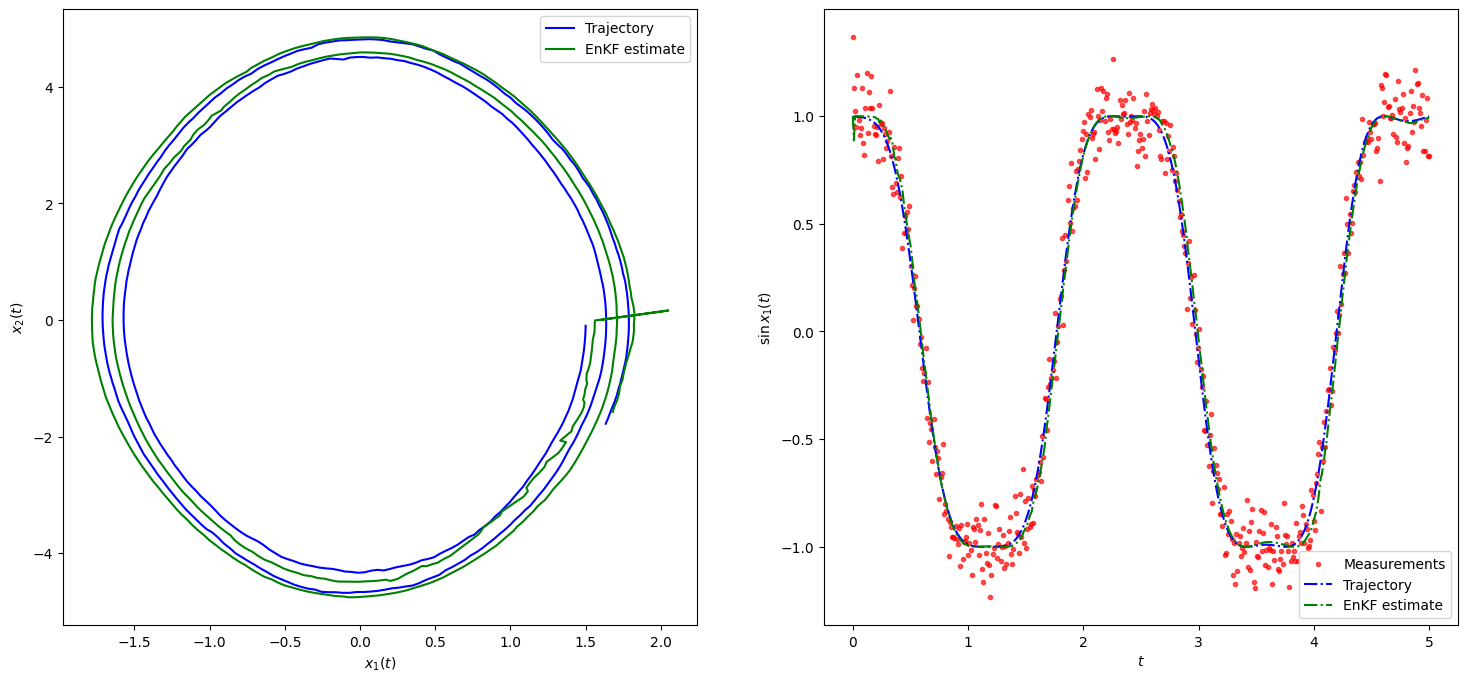

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
x1 = xTrue  # states
x2 = enkf_m # KF estimate
y  = y      # Measurements
timeline = T*dt
axes[1].scatter(timeline, y, marker=".", label="Measurements", color="red", alpha=0.66)
#axes[1].plot(timeline, np.sin(x1[0, :]), linestyle="dashdot", label="Trajectory", color="blue")
axes[1].plot(timeline, np.sin(x1[:, 0]), linestyle="dashdot", label="Trajectory", color="blue")
axes[1].plot(timeline, np.sin(x2[:, 0]), linestyle="dashdot", label="EnKF estimate", color="green")
#axes[0].plot(x1[0, :], x1[1, :], label="Trajectory", color="blue")
axes[0].plot(x1[:, 0], x1[:, 1], label="Trajectory", color="blue")
axes[0].plot(x2[:, 0], x2[:, 1], label="EnKF estimate", color="green")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('$x_1(t)$')
axes[1].set_xlabel('$t$')
axes[0].set_ylabel('$ x_2(t)$')
axes[1].set_ylabel('$\sin x_1(t)$')

plt.show()

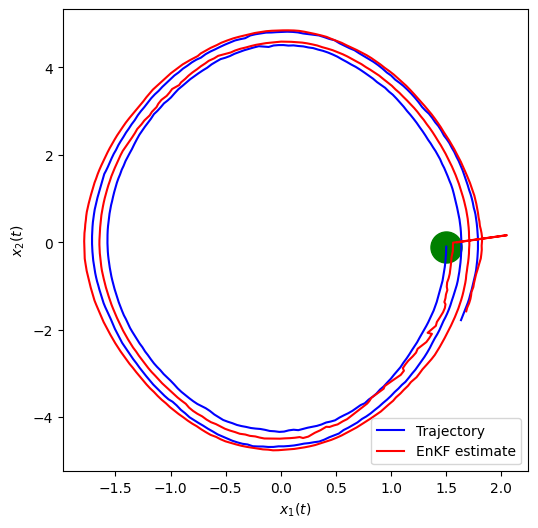

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6))
plt.scatter(x1[0, 0], x1[0, 1], marker="o", color="green", s=500)
plt.plot(x1[:, 0], x1[:, 1], label="Trajectory", color="blue")
plt.plot(x2[:, 0], x2[:, 1], label="EnKF estimate", color="red")
plt.xlabel('$x_1(t)$')
plt.ylabel('$x_2(t)$')
plt.legend()
plt.show()

:::{admonition} Observations
:class: warning

The ensemble Kalman filter tracks rapidly, smoothly and accurately the noisy trajectory of the pendulum. This can be compared to the performance of the EKF (extended Kalman filter) in Example 2, Section 4, that was less accurate (took longer to catch up) and was more noisy.

Note that the error/anomaly covariance elements, $P_{ii},$ are noisy, since they are empirically averaged quantities.

:::

